In [1]:
#load benchmarks problems

import numpy as np

eqc = np.load('eqcS.npy',allow_pickle=True).item() 
class prb:   #this will be your black box function
    def __init__(self,prob,noisy_level):
        # function for generating data
        self.func=prob['func']
        # number of constraints
        self.n_con=prob['n_con']
        # noise level
        self.nl=noisy_level
        # constraints
        self.con=[]
        for i in range(self.n_con):
            self.con.append(prob['con'+str(i+1)])
    def datcol(self,x):
        try:
            # eval takes string type input and evaluates python code. Input can be
            #a mathematical function or a python function which will be called.
            y = eval(self.func)
        except:
            x = np.array([x])
            y = eval(self.func)
        return float(y)
    def constraint(self,x):
        # Appears to evaluate if the constraints are satisfied
        #returns 1 if all constraints are satisfied, else -1
        try:     
            m,n=np.shape(x)
        except:
            x = np.array([x])
            m,n=np.shape(x)
        y=np.empty((self.n_con))
        for i in range(self.n_con):
            y[i]=eval(self.con[i])     
        if y.all() == 1.:
            label = 1.
        else:
            label = -1.
        return label
    
bcp=np.load('bcp8.npy',allow_pickle=True).item()

class benchmark:
    def __init__(self,func,noisy_level):
        self.func = str(func)
        self.nl = noisy_level
    def datcol(self,x):
        try:
            y = eval(self.func)
        except:
            x = np.array([x])
            y = eval(self.func)
        return float(y)

# Helper functions from Lucas

In [2]:
# Find and replace function for editing function strings
def multiple_replace(_string:str, find_replace:list):
    new_string = _string
    for find,replace in find_replace:
        new_string = new_string.replace(find,replace)
    return new_string

# Create usable form of the function to pass to optimizers
def get_usable_fxn(dimension: int, fxn_form: str):
    find_rep_list = [('x[:,{}]'.format(dimension-1-i),'x["{}"]'.format(dimension-1-i)) for i in range(dimension)]
    opt_form = multiple_replace(fxn_form, find_rep_list)
    return opt_form

# Create search space
def create_search_space(dimension: int, xlb: list, xub: list, resolution: int = 100):
    search_space = {str(i):np.linspace(xlb[i],xub[i],resolution) for i in range(dimension)}
    return search_space

# Create a container for objective function - need to use eval to evaluate string version of function, but can't pass that
#directly to optimizer - there is probably a better way to do this, possibly using wrappers. Not worth time right now.
def create_parent_fxn(search_space,opt_form):
    search_space = search_space
    opt_form = opt_form
    def objective_fxn(search_space):
        #clear_output(wait=True)
        x = search_space
        return -1*eval(opt_form)
    return objective_fxn

# Additional Helper Functions

In [3]:
def get_valid_problems(names):
    """ 
    Some provided solutions may be invalid. This function returns valid/invalid solutions
    """

    valid_problems = []
    invalid_problems = []
    for name in names: 
        dims = bcp[f'{name}']['n']
        try:
            assert len(bcp[f'{name}']['xub']) == dims and len(bcp[f'{name}']['xlb']) == dims
            assert len(bcp[f'{name}']['xopt']) == dims 
            valid_problems.append(name)
        except:
            invalid_problems.append(name)
            continue

    print(f"There are {len(valid_problems)} valid problems and {len(invalid_problems)} invalid problems")
    
    return valid_problems, invalid_problems

def get_perturbed_solutions(test_fxn):

    """
    Returns perturbed optimal solutions for a given input problem 
    """

    dims = test_fxn['n']
    perturbed_solutions = []

    for dim in range(dims):
        opt = test_fxn['xopt'][dim]       
        perturbation = np.random.uniform(-5, 5) / 100
        if opt != 0.0: perturbed_solution = np.array([opt + opt*perturbation])
        else: perturbed_solution = np.array([perturbation])
        perturbed_solutions.append(perturbed_solution)

        #stdev = np.std(np.array([test_fxn['xub'][dim], test_fxn['xlb'][dim]]), axis=0)
        #perturbed_solution = np.random.normal(opt, stdev*0.1, 1)

    return np.concatenate(perturbed_solutions)

def get_all_perturbed_solutions(names):

    """
    Returns perturbed initial guesses for all valid problems as a list of np arrays
    """

    valid_problems, _ = get_valid_problems(names)
    perturbed_solutions = []
    percent_differences = []

    for problem in valid_problems:
        test_fxn = bcp[f'{problem}']
        dims = test_fxn['n']
        perturbed_solution = get_perturbed_solutions(test_fxn).astype(float)
        optimal_solution = test_fxn['xopt'].astype(float)
        percent_diff = np.divide(abs(perturbed_solution - optimal_solution), abs(optimal_solution), 
                                out=np.zeros_like(optimal_solution), where=optimal_solution!=0) * 100.0
        assert max(percent_diff) <= 5 # we sampled perturbations from uniform(-5,5)
        assert len(perturbed_solution) == dims
        perturbed_solutions.append(perturbed_solution)
        percent_differences.append(percent_diff)

    return perturbed_solutions, percent_differences


def get_all_initial_guesses(names):

    """
    Returns perturbed initial guesses for all valid problems as a list of dicts
    """

    valid_problems, _ = get_valid_problems(names)
    all_initial_guesses = []

    for problem in valid_problems:
        test_fxn = bcp[f'{problem}']
        dims = test_fxn['n']
        perturbed_solution = get_perturbed_solutions(test_fxn).astype(float)
        optimal_solution = test_fxn['xopt'].astype(float)
        percent_diff = np.divide(abs(perturbed_solution - optimal_solution), abs(optimal_solution), 
                                out=np.zeros_like(optimal_solution), where=optimal_solution!=0) * 100.0
        assert max(percent_diff) <= 5 # we sampled perturbations from uniform(-5,5)
        assert len(perturbed_solution) == dims

        initial_guess = {str(i):perturbed_solution[i] for i in range(dims)}
        all_initial_guesses.append(initial_guess)

    return all_initial_guesses


def get_solutions(problems, solvers, all_initial_guesses):

    names = list(bcp.keys())
    final_solns = {}

    for problem in problems:

        test_fxn = bcp[f'{problem}']
        fxn_form = test_fxn['func']
        xlb = test_fxn['xlb']
        xub = test_fxn['xub']
        ndim = test_fxn['n']

        opt_form = get_usable_fxn(ndim, fxn_form)
        search_space = create_search_space(ndim, xlb, xub, resolution=100)
        fxn = create_parent_fxn(search_space,opt_form)

        initial_guess = all_initial_guesses[names.index(f'{problem}')]
        initialize={"warm_start":[initial_guess]}

        optimum = {}
        for f in solvers:
            opt = f(search_space) # initialize optimizer
            opt.search(fxn, n_iter=2500) # run optimizer
            #opt.search_data.to_csv('./{}.txt'.format(f.__name__), sep='\t', index=False)
            optimum[f.__name__] = -1*opt.best_score

        opts = ['Solver\tOptimum']
        for i in optimum.keys():
            tmp_opt = optimum[i]
            opts += ['{}\t{}'.format(i,tmp_opt)]
        with open(f'{problem}-refinement.txt', 'w') as f:
            print('\n'.join(opts),file=f)

        final_solns[f'{problem}'] = optimum

    return final_solns


def get_solver_names(solvers):

    """ 
    Function to process strings of solvers
    """

    solver_names = []
    for i in range(len(solvers)):
        solver_name = str(solvers[i])
        # All solver names are after 4th "." 
        idx = solver_name.find(".", solver_name.find(".", solver_name.find(".", solver_name.find(".") + 1) + 1) + 1)

        # Select the substring after the 4th dot
        solver_name = solver_name[idx+1:]
        solver_name = solver_name.replace("'", "")
        solver_name = solver_name.replace(">", "")
        solver_names.append(solver_name)
    
    return solver_names

def get_maes(problems, solver_names, solver_solutions):

    """
    Get MAEs for a list of specified problems, ground truth solutions, and solution obtained
    by a list of solvers
    """
    from sklearn.metrics import mean_absolute_error

    maes = {}

    for solver_name in solver_names:
        solver_opts = [v[f'{solver_name}'] for v in solver_solutions.values()]
        true_opts = [bcp[f'{problem}']['yopt'] for problem in problems]
        mae = mean_absolute_error(solver_opts, true_opts)
        maes[f'{solver_name}'] = mae

    return maes

# Refinement Ability (Objective 3)

Note: I am working on a separate notebook here so that it is clearer since the previous notebook is already pretty crowded. The function get_all_initial_guesses produces perturbed initial guesses for all specified input problems (names). Note that code already loops through solvers/problems, it's just a matter of adding all solvers to 'solvers' and all benchmarks to 'problems'. I am not adding all problems since many of them give catastrophic solutions. 

In [4]:
names = list(bcp.keys())
all_initial_guesses = get_all_initial_guesses(names)

There are 263 valid problems and 2 invalid problems


In [5]:
from gradient_free_optimizers import RandomSearchOptimizer,RandomRestartHillClimbingOptimizer,RandomAnnealingOptimizer,PatternSearch,PowellsMethod,GridSearchOptimizer

#problems = names[:5]
problems = ['BeckerLago', 'AluffiPentini']
solvers = [RandomSearchOptimizer,RandomRestartHillClimbingOptimizer,RandomAnnealingOptimizer,PatternSearch,PowellsMethod,GridSearchOptimizer]
solver_names = get_solver_names(solvers)
solver_solutions = get_solutions(problems, solvers, all_initial_guesses)
maes = get_maes(problems, solver_names, solver_solutions)


Results: 'objective_fxn'  
   Best score: -0.00045913682277321253  
   Best parameter:
      '0' : 5.015151515151516  
      '1' : 5.015151515151516  
 
   Random seed: 1404932931  
 
   Evaluation time   : 0.1193699836730957 sec    [77.71 %]
   Optimization time : 0.03423762321472168 sec    [22.29 %]
   Iteration time    : 0.15360760688781738 sec    [16275.24 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 4.994949494949495  
      '1' : 4.994949494949495  
 
   Random seed: 280356761  
 
   Evaluation time   : 0.053124427795410156 sec    [32.33 %]
   Optimization time : 0.11119604110717773 sec    [67.67 %]
   Iteration time    : 0.1643204689025879 sec    [15214.17 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 4.994949494949495  
      '1' : 4.994949494949495  
 
   Random seed: 471526541  
 
   Evaluation time   : 0.039710044860839844 sec    [20.42 %]
   Optimization time : 0.15474796295166016 sec    [79.58 %]
   Iteration time    : 0.1944580078125 sec    [12856.25 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 4.994949494949495  
      '1' : 5.005050505050505  
 
   Random seed: 1452816658  
 
   Evaluation time   : 0.03579235076904297 sec    [9.11 %]
   Optimization time : 0.35728025436401367 sec    [90.89 %]
   Iteration time    : 0.39307260513305664 sec    [6360.15 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 4.994949494949495  
      '1' : 4.994949494949495  
 
   Random seed: 379151011  
 
   Evaluation time   : 0.04962873458862305 sec    [19.1 %]
   Optimization time : 0.21021246910095215 sec    [80.9 %]
   Iteration time    : 0.2598412036895752 sec    [9621.26 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 4.994949494949495  
      '1' : 5.005050505050505  
 
   Random seed: 968266404  
 
   Evaluation time   : 0.12584567070007324 sec    [52.75 %]
   Optimization time : 0.11273598670959473 sec    [47.25 %]
   Iteration time    : 0.23858165740966797 sec    [10478.59 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.3523230661938065  
   Best parameter:
      '0' : -1.0477377848724345  
      '1' : -0.011111111111111072  
 
   Random seed: 1430468992  
 
   Evaluation time   : 0.08216524124145508 sec    [70.82 %]
   Optimization time : 0.03385186195373535 sec    [29.18 %]
   Iteration time    : 0.11601710319519043 sec    [21548.55 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.35232306866772606  
   Best parameter:
      '0' : -1.0456232787475657  
      '1' : 0.011111111111111072  
 
   Random seed: 1934527417  
 
   Evaluation time   : 0.05012059211730957 sec    [28.95 %]
   Optimization time : 0.12299299240112305 sec    [71.05 %]
   Iteration time    : 0.17311358451843262 sec    [14441.39 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.35232306866772606  
   Best parameter:
      '0' : -1.0456232787475657  
      '1' : -0.011111111111111072  
 
   Random seed: 1867877941  
 
   Evaluation time   : 0.043999433517456055 sec    [24.55 %]
   Optimization time : 0.1352379322052002 sec    [75.45 %]
   Iteration time    : 0.17923736572265625 sec    [13947.98 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.35232306866772606  
   Best parameter:
      '0' : -1.0456232787475657  
      '1' : -0.011111111111111072  
 
   Random seed: 1050330310  
 
   Evaluation time   : 0.03613996505737305 sec    [8.99 %]
   Optimization time : 0.3659987449645996 sec    [91.01 %]
   Iteration time    : 0.40213871002197266 sec    [6216.76 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.35232306866772606  
   Best parameter:
      '0' : -1.0456232787475657  
      '1' : 0.011111111111111072  
 
   Random seed: 1318704067  
 
   Evaluation time   : 0.04355573654174805 sec    [17.28 %]
   Optimization time : 0.20844078063964844 sec    [82.72 %]
   Iteration time    : 0.2519965171813965 sec    [9920.77 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.35232306866772606  
   Best parameter:
      '0' : -1.0456232787475657  
      '1' : -0.011111111111111072  
 
   Random seed: 1596929216  
 
   Evaluation time   : 0.08561825752258301 sec    [43.61 %]
   Optimization time : 0.11069083213806152 sec    [56.39 %]
   Iteration time    : 0.19630908966064453 sec    [12735.02 iter/sec]
 


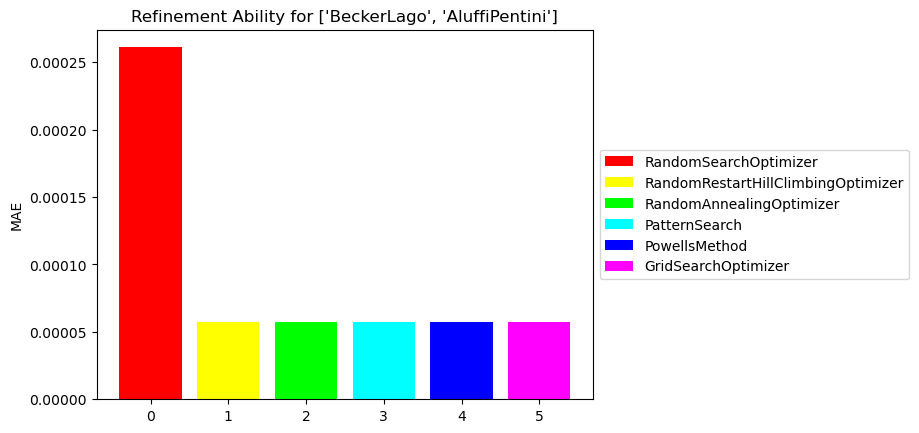

In [6]:
import matplotlib.pyplot as plt
import colorsys

num_colors = len(solvers)
hue_values = [i / num_colors for i in range(num_colors)]

selected_colors = [colorsys.hsv_to_rgb(hue, 1.0, 1.0) + (1.0,) for hue in hue_values]
bars = plt.bar(range(len(maes)), list(maes.values()), color=selected_colors)
handles = [bar for bar in bars]
plt.legend(handles, maes.keys(), loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel("MAE")
plt.title(f"Refinement Ability for {problems}")
plt.show()
